# RoBERTa Fine Tuning - Performance Comparison with Frozen Weights

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.6 MB/s eta 0:00:00


# Installing Libraries

In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 13.9 MB/s eta 0:00:00


# Downloading the Dataset and Exploring

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
dataset['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})

In [ ]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

#Defining Variables which will be used later

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

# Creating the Dataset Class

In [ ]:
class AGnewsData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Phrase
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation = True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids),
            'mask': torch.tensor(mask),
            'token_type_ids': torch.tensor(token_type_ids),
            'targets': torch.tensor(self.targets[index])
        }

# Number of Datapoints in the Training and Testing set

In [ ]:
tr_data = {'Phrase': dataset['train']['text'],
        'Sentiment': dataset['train']['label']}
ts_data = {'Phrase': dataset['test']['text'],
        'Sentiment': dataset['test']['label']}

train_data = pd.DataFrame(tr_data)
test_data = pd.DataFrame(ts_data)

training_set = AGnewsData(train_data, tokenizer, MAX_LEN)
testing_set = AGnewsData(test_data, tokenizer, MAX_LEN)

print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

TRAIN Dataset: (120000, 2)
TEST Dataset: (7600, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# Importing RoBERTa Model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
model_frozen = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

# Number of Trainable Parameters in the RoBERTa Model

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

124648708


In [ ]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
model_frozen.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

# Freezing Weights

In [ ]:
for name, param in model_frozen.named_parameters():  
  if name.startswith('roberta.encoder.layer.10') or name.startswith('roberta.encoder.layer.11') or name.startswith('classifier'):
    continue
  param.requires_grad = False

# Number of Trainable Parameters in the Frozen RoBERTa Model

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model_frozen.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

14769412


# Initializing Loss Function and Optimizer

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calcuate_metrics(preds, targets):
    accuracy = accuracy_score(preds.cpu().numpy(), targets.cpu().numpy())
    precision = precision_score(preds.cpu().numpy(), targets.cpu().numpy(), average = 'macro', zero_division = 1)
    recall = recall_score(preds.cpu().numpy(), targets.cpu().numpy(), average = 'macro', zero_division = 1)
    f1 = f1_score(preds.cpu().numpy(), targets.cpu().numpy(), average = 'macro', zero_division = 1)
    return [accuracy, precision, recall, f1]

# Training Function

In [ ]:
def train(model, epoch, modelTrainLoss, modelTrainAccuracy, modelTrainPrecision, modelTrainRecall, modelTrainF1score):
    tr_loss = 0
    n_accuracy = 0
    n_precision = 0
    n_recall = 0
    n_f1score = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0), position=0, leave=True):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        outputs = model(ids, mask, token_type_ids).logits
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        metrics = calcuate_metrics(big_idx, targets)
        n_accuracy += metrics[0]
        n_precision += metrics[1]
        n_recall += metrics[2]
        n_f1score += metrics[3]

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%500==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_accuracy*100)/nb_tr_steps 
            prec_step = (n_precision*100)/nb_tr_steps 
            reca_step = (n_recall*100)/nb_tr_steps 
            f1sc_step = (n_f1score*100)/nb_tr_steps 
            print(f"Training Loss per 500 steps: {loss_step}")
            print(f"Training Accuracy per 500 steps: {accu_step}")
            print(f"Training Precision per 500 steps: {prec_step}")
            print(f"Training Recall per 500 steps: {reca_step}")
            print(f"Training F1 Score per 500 steps: {f1sc_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        modelTrainLoss.append(tr_loss)
        modelTrainAccuracy.append(n_accuracy)
        modelTrainPrecision.append(n_precision)
        modelTrainRecall.append(n_recall)
        modelTrainF1score.append(n_f1score)

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_accuracy*100)/nb_tr_steps 
    epoch_prec = (n_precision*100)/nb_tr_steps 
    epoch_reca = (n_recall*100)/nb_tr_steps 
    epoch_f1sc = (n_f1score*100)/nb_tr_steps 
    print(f'Final Total Loss for Epoch {epoch}: {epoch_loss}')
    print(f'Final Total Accuracy for Epoch {epoch}: {epoch_accu}')
    print(f'Final Total Precision for Epoch {epoch}: {epoch_prec}')
    print(f'Final Total Recall for Epoch {epoch}: {epoch_reca}')
    print(f'Final Total F1 Score for Epoch {epoch}: {epoch_f1sc}')

    return 

# Testing Function

In [ ]:
def valid(model, testing_loader, modelTestLoss, modelTestAccuracy, modelTestPrecision, modelTestRecall, modelTestF1score):
    tr_loss = 0
    n_accuracy = 0
    n_precision = 0
    n_recall = 0
    n_f1score = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.eval()
    with torch.no_grad():
        for _,data in tqdm(enumerate(testing_loader, 0), position=0, leave=True):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids).logits
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            metrics = calcuate_metrics(big_idx, targets)
            n_accuracy += metrics[0]
            n_precision += metrics[1]
            n_recall += metrics[2]
            n_f1score += metrics[3]

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            modelTestLoss.append(tr_loss)
            modelTestAccuracy.append(n_accuracy)
            modelTestPrecision.append(n_precision)
            modelTestRecall.append(n_recall)
            modelTestF1score.append(n_f1score)

            

    valid_loss = tr_loss/nb_tr_steps
    valid_accu = (n_accuracy*100)/nb_tr_steps 
    valid_prec = (n_precision*100)/nb_tr_steps 
    valid_reca = (n_recall*100)/nb_tr_steps 
    valid_f1sc = (n_f1score*100)/nb_tr_steps 
    print(f'Final Total Loss for Validation {epoch}: {valid_loss}')
    print(f'Final Total Accuracy for Validation {epoch}: {valid_accu}')
    print(f'Final Total Precision for Validation {epoch}: {valid_prec}')
    print(f'Final Total Recall for Validation {epoch}: {valid_reca}')
    print(f'Final Total F1 Score for Validation {epoch}: {valid_f1sc}')
    
    return


# Full RoBERTa Model Training and Testing

In [ ]:
EPOCHS = 1

modelTrainLoss = []
modelTrainAccuracy = []
modelTrainPrecision = []
modelTrainRecall = []
modelTrainF1score = []

modelTestLoss = []
modelTestAccuracy = []
modelTestPrecision = []
modelTestRecall = []
modelTestF1score = []

for epoch in range(EPOCHS):
    train(model, epoch, modelTrainLoss, modelTrainAccuracy, modelTrainPrecision, modelTrainRecall, modelTrainF1score)
    valid(model, testing_loader, modelTestLoss, modelTestAccuracy, modelTestPrecision, modelTestRecall, modelTestF1score)

0it [00:00, ?it/s]

Training Loss per 500 steps: 1.4605903625488281
Training Accuracy per 500 steps: 25.0
Training Precision per 500 steps: 33.33333333333333
Training Recall per 500 steps: 42.857142857142854
Training F1 Score per 500 steps: 14.814814814814817


500it [02:56,  2.82it/s]

Training Loss per 500 steps: 0.4605862473150689
Training Accuracy per 500 steps: 83.65768463073853
Training Precision per 500 steps: 85.14886892880907
Training Recall per 500 steps: 87.0034138073061
Training F1 Score per 500 steps: 79.8546989714655


1000it [05:57,  2.76it/s]

Training Loss per 500 steps: 0.38486815945475134
Training Accuracy per 500 steps: 86.87562437562437
Training Precision per 500 steps: 87.62071262071247
Training Recall per 500 steps: 88.91257551971826
Training F1 Score per 500 steps: 83.11608365179801


1500it [08:59,  2.74it/s]

Training Loss per 500 steps: 0.34499799219182853
Training Accuracy per 500 steps: 88.24117255163225
Training Precision per 500 steps: 88.8028351469392
Training Recall per 500 steps: 89.89985512303967
Training F1 Score per 500 steps: 84.70265493999666


2000it [12:02,  2.74it/s]

Training Loss per 500 steps: 0.32650551301516084
Training Accuracy per 500 steps: 88.84307846076962
Training Precision per 500 steps: 89.46571357178588
Training Recall per 500 steps: 90.20104035283968
Training F1 Score per 500 steps: 85.40703107857024


2500it [15:04,  2.72it/s]

Training Loss per 500 steps: 0.3112079762823519
Training Accuracy per 500 steps: 89.37425029988005
Training Precision per 500 steps: 89.93309025596128
Training Recall per 500 steps: 90.5317000184054
Training F1 Score per 500 steps: 85.99098132234869


3000it [18:07,  2.75it/s]

Training Loss per 500 steps: 0.29859281140691496
Training Accuracy per 500 steps: 89.85754748417195
Training Precision per 500 steps: 90.353037082877
Training Recall per 500 steps: 90.87060926780994
Training F1 Score per 500 steps: 86.51073069808476


3500it [21:09,  2.74it/s]

Training Loss per 500 steps: 0.2879087340575636
Training Accuracy per 500 steps: 90.21708083404741
Training Precision per 500 steps: 90.71281787969839
Training Recall per 500 steps: 91.11854662840055
Training F1 Score per 500 steps: 86.96167626580353


4000it [24:12,  2.75it/s]

Training Loss per 500 steps: 0.27870808453076806
Training Accuracy per 500 steps: 90.50549862534366
Training Precision per 500 steps: 90.98652916135987
Training Recall per 500 steps: 91.32279430142398
Training F1 Score per 500 steps: 87.31300499420956


4500it [27:15,  2.73it/s]

Training Loss per 500 steps: 0.27392178186252913
Training Accuracy per 500 steps: 90.6770717618307
Training Precision per 500 steps: 91.11238067025592
Training Recall per 500 steps: 91.42215310177907
Training F1 Score per 500 steps: 87.44704073769822


5000it [30:17,  2.73it/s]

Training Loss per 500 steps: 0.2671166245706031
Training Accuracy per 500 steps: 90.92681463707258
Training Precision per 500 steps: 91.31393562557287
Training Recall per 500 steps: 91.66700390080663
Training F1 Score per 500 steps: 87.77786650462092


5500it [33:20,  2.74it/s]

Training Loss per 500 steps: 0.2606058435947471
Training Accuracy per 500 steps: 91.13343028540265
Training Precision per 500 steps: 91.49732155481098
Training Recall per 500 steps: 91.82290449355506
Training F1 Score per 500 steps: 88.02938985042202


6000it [36:22,  2.73it/s]

Training Loss per 500 steps: 0.2553334822541469
Training Accuracy per 500 steps: 91.29311781369772
Training Precision per 500 steps: 91.65925388096696
Training Recall per 500 steps: 91.9678234844457
Training F1 Score per 500 steps: 88.26343487774868


6500it [39:25,  2.75it/s]

Training Loss per 500 steps: 0.25105514639876514
Training Accuracy per 500 steps: 91.43593293339487
Training Precision per 500 steps: 91.80845498738927
Training Recall per 500 steps: 92.0961274578028
Training F1 Score per 500 steps: 88.48390517172182


7000it [42:27,  2.75it/s]

Training Loss per 500 steps: 0.24729594403225755
Training Accuracy per 500 steps: 91.56191972575347
Training Precision per 500 steps: 91.96292819846634
Training Recall per 500 steps: 92.19410832466144
Training F1 Score per 500 steps: 88.67837212198668


7500it [45:30,  2.74it/s]

Training Loss per 500 steps: 0.24306035040468157
Training Accuracy per 500 steps: 91.68777496333823
Training Precision per 500 steps: 92.08908653449423
Training Recall per 500 steps: 92.29522836108669
Training F1 Score per 500 steps: 88.83738184448018


8000it [48:33,  2.75it/s]

Training Loss per 500 steps: 0.2402854690905239
Training Accuracy per 500 steps: 91.74946881639795
Training Precision per 500 steps: 92.15388751009354
Training Recall per 500 steps: 92.34059036271317
Training F1 Score per 500 steps: 88.92767746910903


8500it [51:35,  2.75it/s]

Training Loss per 500 steps: 0.23818414694630816
Training Accuracy per 500 steps: 91.81860957534408
Training Precision per 500 steps: 92.2119853313249
Training Recall per 500 steps: 92.3827238812247
Training F1 Score per 500 steps: 88.99215920316293


9000it [54:38,  2.72it/s]

Training Loss per 500 steps: 0.23578089114111764
Training Accuracy per 500 steps: 91.91339851127653
Training Precision per 500 steps: 92.28530824617435
Training Recall per 500 steps: 92.44873805908752
Training F1 Score per 500 steps: 89.09599436082506


9500it [57:41,  2.75it/s]

Training Loss per 500 steps: 0.23248480484240994
Training Accuracy per 500 steps: 92.02452373434376
Training Precision per 500 steps: 92.37985809346755
Training Recall per 500 steps: 92.54655107315388
Training F1 Score per 500 steps: 89.23641862937637


10000it [1:00:43,  2.74it/s]

Training Loss per 500 steps: 0.22929664326964586
Training Accuracy per 500 steps: 92.13578642135786
Training Precision per 500 steps: 92.48656285165139
Training Recall per 500 steps: 92.63789494066476
Training F1 Score per 500 steps: 89.36794487476858


10500it [1:03:46,  2.75it/s]

Training Loss per 500 steps: 0.22719383862774822
Training Accuracy per 500 steps: 92.19717169793353
Training Precision per 500 steps: 92.54799051639799
Training Recall per 500 steps: 92.67930265144791
Training F1 Score per 500 steps: 89.43595364329059


11000it [1:06:48,  2.74it/s]

Training Loss per 500 steps: 0.22564724861254273
Training Accuracy per 500 steps: 92.26206708481047
Training Precision per 500 steps: 92.62091613605061
Training Recall per 500 steps: 92.72126235277268
Training F1 Score per 500 steps: 89.504827304118


11500it [1:09:51,  2.75it/s]

Training Loss per 500 steps: 0.22363674084022048
Training Accuracy per 500 steps: 92.33110164333536
Training Precision per 500 steps: 92.67961516113776
Training Recall per 500 steps: 92.79426530198138
Training F1 Score per 500 steps: 89.60167322396673


12000it [1:12:54,  2.73it/s]

Training Loss per 500 steps: 0.22215042167112561
Training Accuracy per 500 steps: 92.3829264227981
Training Precision per 500 steps: 92.72390991226821
Training Recall per 500 steps: 92.8412480176908
Training F1 Score per 500 steps: 89.65592102549438


12500it [1:15:56,  2.74it/s]

Training Loss per 500 steps: 0.220365436585335
Training Accuracy per 500 steps: 92.44660427165827
Training Precision per 500 steps: 92.77752700418768
Training Recall per 500 steps: 92.90689284539674
Training F1 Score per 500 steps: 89.74317912782844


13000it [1:18:59,  2.75it/s]

Training Loss per 500 steps: 0.2187182916562628
Training Accuracy per 500 steps: 92.50826859472349
Training Precision per 500 steps: 92.84119170320093
Training Recall per 500 steps: 92.96667655601463
Training F1 Score per 500 steps: 89.84067982856558


13500it [1:22:01,  2.73it/s]

Training Loss per 500 steps: 0.21787324831731003
Training Accuracy per 500 steps: 92.52647952003555
Training Precision per 500 steps: 92.85634191705807
Training Recall per 500 steps: 92.98157808416165
Training F1 Score per 500 steps: 89.8596711592049


14000it [1:25:04,  2.74it/s]

Training Loss per 500 steps: 0.216384870996877
Training Accuracy per 500 steps: 92.57999428612241
Training Precision per 500 steps: 92.91031791379814
Training Recall per 500 steps: 93.02823466124148
Training F1 Score per 500 steps: 89.92837633140148


14500it [1:28:07,  2.74it/s]

Training Loss per 500 steps: 0.21500634447828887
Training Accuracy per 500 steps: 92.62895662368112
Training Precision per 500 steps: 92.9590104896962
Training Recall per 500 steps: 93.08433572725524
Training F1 Score per 500 steps: 90.00527550972389


15000it [1:31:09,  2.74it/s]


Final Total Loss for Epoch 0: 0.2136350967808937
Final Total Accuracy for Epoch 0: 92.68166666666667
Final Total Precision for Epoch 0: 93.01890740740544
Final Total Recall for Epoch 0: 93.13667460317276
Final Total F1 Score for Epoch 0: 90.08461772795154


1900it [01:57, 16.16it/s]

Final Total Loss for Validation 0: 0.16738089679522858
Final Total Accuracy for Validation 0: 94.5657894736842
Final Total Precision for Validation 0: 95.20614035087713
Final Total Recall for Validation 0: 95.52485380116957
Final Total F1 Score for Validation 0: 92.2046574770261


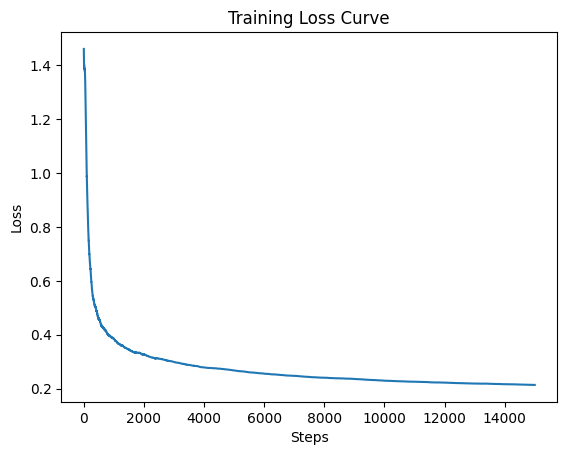

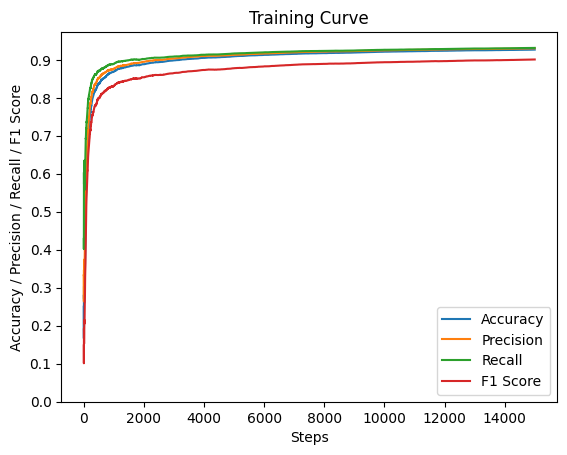

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from operator import truediv
  
x = [i for i in range(1, 15001)] 
  
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(x, list(map(truediv, modelTrainLoss, x)))
plt.show()
  
plt.title("Training Curve")
plt.xlabel("Steps")
plt.ylabel("Accuracy / Precision / Recall / F1 Score")
plt.plot(x, list(map(truediv, modelTrainAccuracy, x)), label = "Accuracy")
plt.plot(x, list(map(truediv, modelTrainPrecision, x)), label = "Precision")
plt.plot(x, list(map(truediv, modelTrainRecall, x)), label = "Recall")
plt.plot(x, list(map(truediv, modelTrainF1score, x)), label = "F1 Score")
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.show()

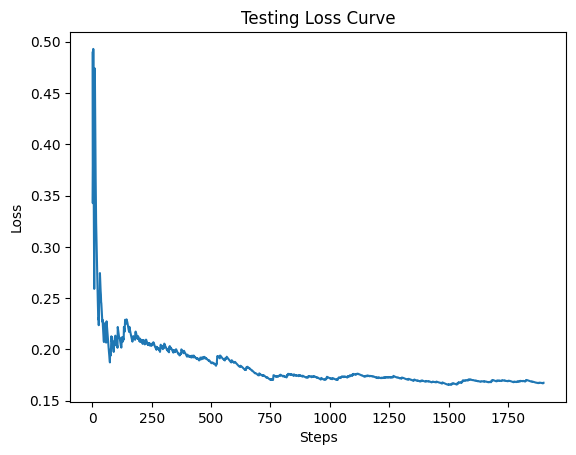

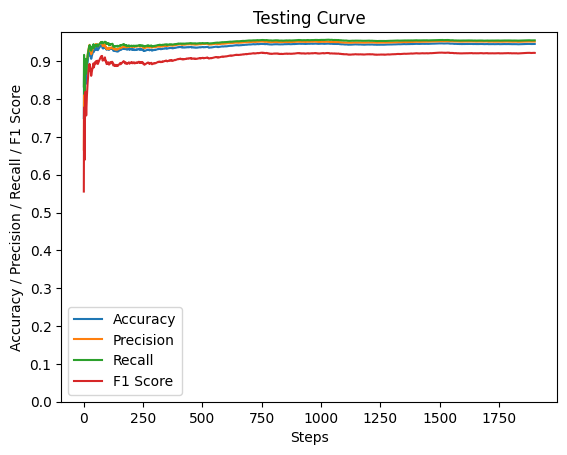

In [ ]:
x = [i for i in range(1, 1901)] 
  
plt.title("Testing Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(x, list(map(truediv, modelTestLoss, x)))
plt.show()
  
plt.title("Testing Curve")
plt.xlabel("Steps")
plt.ylabel("Accuracy / Precision / Recall / F1 Score")
plt.plot(x, list(map(truediv, modelTestAccuracy, x)), label = "Accuracy")
plt.plot(x, list(map(truediv, modelTestPrecision, x)), label = "Precision")
plt.plot(x, list(map(truediv, modelTestRecall, x)), label = "Recall")
plt.plot(x, list(map(truediv, modelTestF1score, x)), label = "F1 Score")
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.show()

# Frozen RoBERTa Model Training and Testing

In [ ]:
EPOCHS = 1

modelFrozenTrainLoss = []
modelFrozenTrainAccuracy = []
modelFrozenTrainPrecision = []
modelFrozenTrainRecall = []
modelFrozenTrainF1score = []

modelFrozenTestLoss = []
modelFrozenTestAccuracy = []
modelFrozenTestPrecision = []
modelFrozenTestRecall = []
modelFrozenTestF1score = [] 

for epoch in range(EPOCHS):
    train(model_frozen, epoch, modelFrozenTrainLoss, modelFrozenTrainAccuracy, modelFrozenTrainPrecision, modelFrozenTrainRecall, modelFrozenTrainF1score)
    valid(model_frozen, testing_loader, modelFrozenTestLoss, modelFrozenTestAccuracy, modelFrozenTestPrecision, modelFrozenTestRecall, modelFrozenTestF1score)

1it [00:00,  3.63it/s]

Training Loss per 500 steps: 1.4615602493286133
Training Accuracy per 500 steps: 25.0
Training Precision per 500 steps: 33.33333333333333
Training Recall per 500 steps: 78.57142857142857
Training F1 Score per 500 steps: 18.75


501it [01:33,  5.39it/s]

Training Loss per 500 steps: 1.3957295215534355
Training Accuracy per 500 steps: 24.151696606786427
Training Precision per 500 steps: 29.049955644267037
Training Recall per 500 steps: 50.86594667807248
Training F1 Score per 500 steps: 15.9212313154429


1001it [03:07,  5.26it/s]

Training Loss per 500 steps: 1.3960944485592914
Training Accuracy per 500 steps: 24.225774225774227
Training Precision per 500 steps: 29.21689421689423
Training Recall per 500 steps: 51.082280814423676
Training F1 Score per 500 steps: 15.988720366842278


1501it [04:45,  5.15it/s]

Training Loss per 500 steps: 1.3961257340509363
Training Accuracy per 500 steps: 23.87574950033311
Training Precision per 500 steps: 29.116052261455284
Training Recall per 500 steps: 51.32233273056055
Training F1 Score per 500 steps: 15.793942467826591


2001it [06:21,  5.12it/s]

Training Loss per 500 steps: 1.3957202597774905
Training Accuracy per 500 steps: 24.294102948525737
Training Precision per 500 steps: 29.328183130656843
Training Recall per 500 steps: 51.489369402600204
Training F1 Score per 500 steps: 16.066609598593583


2501it [07:58,  5.14it/s]

Training Loss per 500 steps: 1.395331208584834
Training Accuracy per 500 steps: 24.400239904038386
Training Precision per 500 steps: 29.249744546625795
Training Recall per 500 steps: 51.35360538324345
Training F1 Score per 500 steps: 16.131005695179987


3001it [09:37,  5.00it/s]

Training Loss per 500 steps: 1.3952970847969093
Training Accuracy per 500 steps: 24.333555481506163
Training Precision per 500 steps: 29.198137657817803
Training Recall per 500 steps: 51.387741784484426
Training F1 Score per 500 steps: 16.09893722356229


3501it [11:17,  5.18it/s]

Training Loss per 500 steps: 1.394761544368976
Training Accuracy per 500 steps: 24.478720365609824
Training Precision per 500 steps: 29.32717636230924
Training Recall per 500 steps: 51.475451458313366
Training F1 Score per 500 steps: 16.17698290791684


4001it [12:53,  5.15it/s]

Training Loss per 500 steps: 1.3951109321794937
Training Accuracy per 500 steps: 24.41577105723569
Training Precision per 500 steps: 29.268620344913735
Training Recall per 500 steps: 51.44556122874021
Training F1 Score per 500 steps: 16.087396570400713


4501it [14:30,  5.14it/s]

Training Loss per 500 steps: 1.394930689580121
Training Accuracy per 500 steps: 24.391801821817374
Training Precision per 500 steps: 29.266613592041203
Training Recall per 500 steps: 51.378487761096956
Training F1 Score per 500 steps: 16.073962675273332


5001it [16:07,  5.10it/s]

Training Loss per 500 steps: 1.3947187209458285
Training Accuracy per 500 steps: 24.40761847630474
Training Precision per 500 steps: 29.286975938145584
Training Recall per 500 steps: 51.40782557774143
Training F1 Score per 500 steps: 16.102325183758712


5501it [17:44,  5.07it/s]

Training Loss per 500 steps: 1.3948878714050559
Training Accuracy per 500 steps: 24.41147064170151
Training Precision per 500 steps: 29.264022702942764
Training Recall per 500 steps: 51.47403935215236
Training F1 Score per 500 steps: 16.084129114941494


6001it [19:21,  5.09it/s]

Training Loss per 500 steps: 1.3949694554620218
Training Accuracy per 500 steps: 24.439676720546576
Training Precision per 500 steps: 29.32493063325409
Training Recall per 500 steps: 51.58799922235176
Training F1 Score per 500 steps: 16.103725338644324


6501it [20:59,  5.16it/s]

Training Loss per 500 steps: 1.3948933459157082
Training Accuracy per 500 steps: 24.455852945700663
Training Precision per 500 steps: 29.390118247986113
Training Recall per 500 steps: 51.5662410300735
Training F1 Score per 500 steps: 16.13480095963542


7001it [22:36,  5.16it/s]

Training Loss per 500 steps: 1.3948607244520184
Training Accuracy per 500 steps: 24.53399514355092
Training Precision per 500 steps: 29.348568118386552
Training Recall per 500 steps: 51.611201234290796
Training F1 Score per 500 steps: 16.161585621126967


7501it [24:12,  5.17it/s]

Training Loss per 500 steps: 1.394964115220123
Training Accuracy per 500 steps: 24.46007199040128
Training Precision per 500 steps: 29.341090500102577
Training Recall per 500 steps: 51.587613714996756
Training F1 Score per 500 steps: 16.14970259734281


8001it [25:50,  5.15it/s]

Training Loss per 500 steps: 1.3949416217439221
Training Accuracy per 500 steps: 24.429758780152483
Training Precision per 500 steps: 29.28745265968733
Training Recall per 500 steps: 51.528102637963975
Training F1 Score per 500 steps: 16.11919800193135


8501it [27:27,  5.17it/s]

Training Loss per 500 steps: 1.39493625502827
Training Accuracy per 500 steps: 24.442712622044464
Training Precision per 500 steps: 29.28969374284634
Training Recall per 500 steps: 51.582024430366104
Training F1 Score per 500 steps: 16.1377893194738


9001it [29:04,  5.10it/s]

Training Loss per 500 steps: 1.3950326804147404
Training Accuracy per 500 steps: 24.425063881790912
Training Precision per 500 steps: 29.306838481791324
Training Recall per 500 steps: 51.50437208916858
Training F1 Score per 500 steps: 16.139367998466987


9501it [30:41,  5.06it/s]

Training Loss per 500 steps: 1.3952964176668416
Training Accuracy per 500 steps: 24.338227554994212
Training Precision per 500 steps: 29.27725652938801
Training Recall per 500 steps: 51.40965946775909
Training F1 Score per 500 steps: 16.075119842091777


10001it [32:17,  5.17it/s]

Training Loss per 500 steps: 1.3951550568357585
Training Accuracy per 500 steps: 24.363813618638137
Training Precision per 500 steps: 29.246559471037195
Training Recall per 500 steps: 51.41585742219481
Training F1 Score per 500 steps: 16.056998358143318


10501it [33:55,  5.16it/s]

Training Loss per 500 steps: 1.3951613977288941
Training Accuracy per 500 steps: 24.308399200076185
Training Precision per 500 steps: 29.226923588532195
Training Recall per 500 steps: 51.350470401156734
Training F1 Score per 500 steps: 16.032342684209276


11001it [35:32,  5.18it/s]

Training Loss per 500 steps: 1.395127921036813
Training Accuracy per 500 steps: 24.33415144077811
Training Precision per 500 steps: 29.245988459923762
Training Recall per 500 steps: 51.39840101116431
Training F1 Score per 500 steps: 16.054834680414285


11501it [37:09,  5.11it/s]

Training Loss per 500 steps: 1.3952663120897155
Training Accuracy per 500 steps: 24.257673245804714
Training Precision per 500 steps: 29.199886690322536
Training Recall per 500 steps: 51.34788227524823
Training F1 Score per 500 steps: 16.008179415383257


12001it [38:46,  5.16it/s]

Training Loss per 500 steps: 1.3952416483337369
Training Accuracy per 500 steps: 24.272977251895675
Training Precision per 500 steps: 29.237341993987503
Training Recall per 500 steps: 51.34754974122633
Training F1 Score per 500 steps: 16.020645658384325


12501it [40:22,  5.18it/s]

Training Loss per 500 steps: 1.395271967939449
Training Accuracy per 500 steps: 24.25205983521318
Training Precision per 500 steps: 29.2176736972156
Training Recall per 500 steps: 51.337813609832956
Training F1 Score per 500 steps: 16.003377634847276


13001it [41:59,  5.16it/s]

Training Loss per 500 steps: 1.395286138979584
Training Accuracy per 500 steps: 24.198138604722715
Training Precision per 500 steps: 29.16664530078912
Training Recall per 500 steps: 51.28668521224975
Training F1 Score per 500 steps: 15.969679999370202


13501it [43:36,  5.14it/s]

Training Loss per 500 steps: 1.3951848864193344
Training Accuracy per 500 steps: 24.22042811643582
Training Precision per 500 steps: 29.155360919767567
Training Recall per 500 steps: 51.29886101911435
Training F1 Score per 500 steps: 15.966525988283792


14001it [45:13,  5.19it/s]

Training Loss per 500 steps: 1.3951963556127014
Training Accuracy per 500 steps: 24.205413899007215
Training Precision per 500 steps: 29.163098327444057
Training Recall per 500 steps: 51.25976900176176
Training F1 Score per 500 steps: 15.959943887056413


14501it [46:50,  5.18it/s]

Training Loss per 500 steps: 1.395233036838608
Training Accuracy per 500 steps: 24.150920626163714
Training Precision per 500 steps: 29.118425603926894
Training Recall per 500 steps: 51.25367038179201
Training F1 Score per 500 steps: 15.906291436944674


15000it [48:27,  5.16it/s]


Final Total Loss for Epoch 0: 1.3951644351800283
Final Total Accuracy for Epoch 0: 24.1475
Final Total Precision for Epoch 0: 29.107884920635176
Final Total Recall for Epoch 0: 51.22741137566259
Final Total F1 Score for Epoch 0: 15.904176400759901


1900it [01:56, 16.26it/s]

Final Total Loss for Validation 0: 1.392181879909415
Final Total Accuracy for Validation 0: 24.13157894736842
Final Total Precision for Validation 0: 35.11549707602354
Final Total Recall for Validation 0: 71.13888888888893
Final Total F1 Score for Validation 0: 13.437740183792755


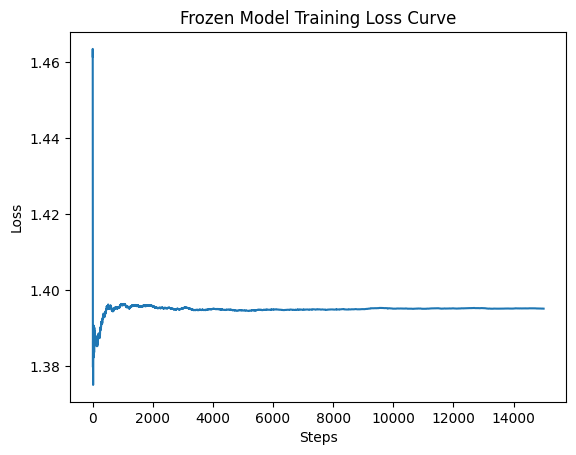

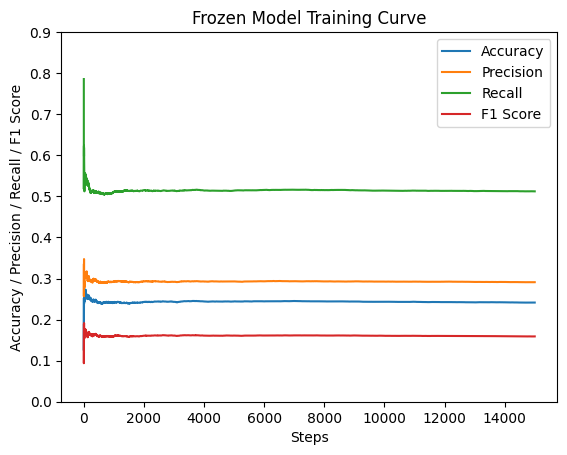

In [ ]:
x = [i for i in range(1, 15001)] 
  
plt.title("Frozen Model Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(x, list(map(truediv, modelFrozenTrainLoss, x)))
plt.show()
  
plt.title("Frozen Model Training Curve")
plt.xlabel("Steps")
plt.ylabel("Accuracy / Precision / Recall / F1 Score")
plt.plot(x, list(map(truediv, modelFrozenTrainAccuracy, x)), label = "Accuracy")
plt.plot(x, list(map(truediv, modelFrozenTrainPrecision, x)), label = "Precision")
plt.plot(x, list(map(truediv, modelFrozenTrainRecall, x)), label = "Recall")
plt.plot(x, list(map(truediv, modelFrozenTrainF1score, x)), label = "F1 Score")
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.show()

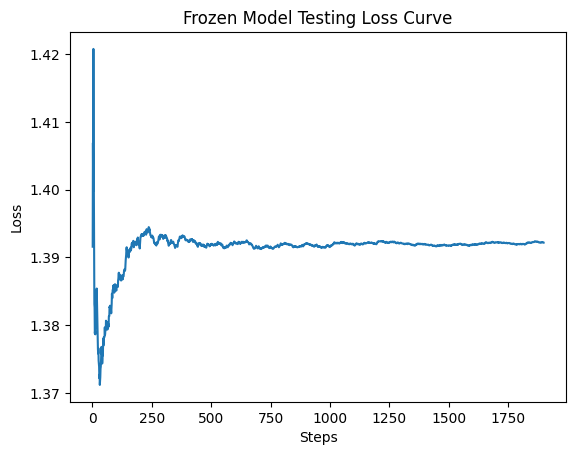

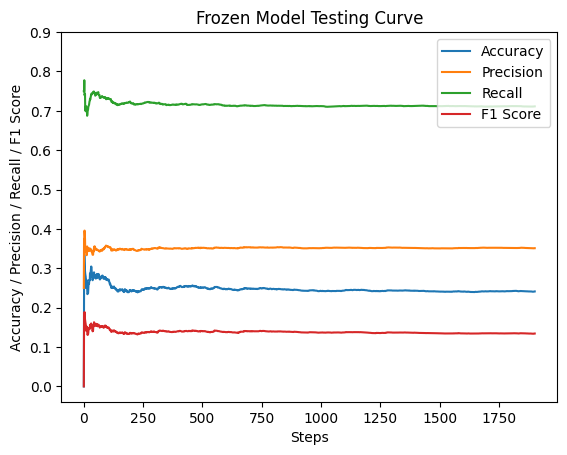

In [ ]:
x = [i for i in range(1, 1901)] 
  
plt.title("Frozen Model Testing Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(x, list(map(truediv, modelFrozenTestLoss, x)))
plt.show()
  
plt.title("Frozen Model Testing Curve")
plt.xlabel("Steps")
plt.ylabel("Accuracy / Precision / Recall / F1 Score")
plt.plot(x, list(map(truediv, modelFrozenTestAccuracy, x)), label = "Accuracy")
plt.plot(x, list(map(truediv, modelFrozenTestPrecision, x)), label = "Precision")
plt.plot(x, list(map(truediv, modelFrozenTestRecall, x)), label = "Recall")
plt.plot(x, list(map(truediv, modelFrozenTestF1score, x)), label = "F1 Score")
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.show()